<a href="https://colab.research.google.com/github/Nomade25/Case-Data-Enginner/blob/main/case_eng_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                                 Case Engenharia de Dados:

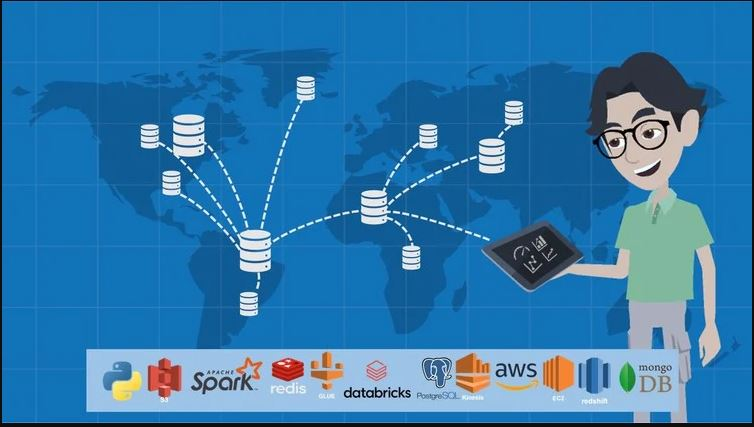


O Case abaixo demonstra um caso analise de dados de um dataset de vendas. Onde a necessidade do cliente após diversas discussões se deu na seguinte necessidade:
- Criação para um modelo StarSchema
- Saida dos dados em formato JSON agrupado a quantidade sobre valor total de venda por país e linha de produto;

#========================= Atividades Desenvolvidas===========
As seguintes manipulações e tratamentos foram realizados com a base:
- Levantamento do bucket no Google Cloud e criação das camadas, Bronze, Prata e Gold para simular arquitetura medalhão;
- Utilização de funções e bibliotecas do Spark e pySpark para tratamentos e carregamento dos dados;
- Criação de função para tratamento dos dados;
- Realizado tipagem dos dados e modelo StarSchema no SparkSQL;
- Data Quality, validações referente a volume e valor dos dados;
- Criação de tabelas deltas dentro do datalake;
- Saida dos dados em modelo JSON, modelo de notebook próprio para um End Point e Consumo de API

# Primeiramente carregar as bibliotecas para utilização do pySpark e Ambiente GCP para criar o bucket:


In [ ]:

#bibliotecas de ambiente GCP pra criar o bucket
from IPython import get_ipython
from IPython.display import display

!pip install gcsfs
!pip install google-cloud-storage
import os

#instalar pyspark
!pip install pyspark

spark = SparkSession.builder.appName("MySparkApplication").getOrCreate()
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql import functions as F
from pyspark.sql.functions import current_timestamp, sum as _sum, col, when, collect_list, input_file_name, row_number, monotonically_increasing_id, dayofyear, year, to_date,struct, to_json
from pyspark.sql.functions import unix_timestamp, from_unixtime, to_timestamp
from pyspark.sql.window import Window
from pyspark.sql.utils import AnalysisException
from google.cloud import storage
from google.cloud.storage import Bucket, Client
from google.cloud.storage.blob import Blob
from google.api_core.exceptions import NotFound



# Levantando o bucket/cluster e camadas no armazenamento


In [ ]:
#credenciais JSON
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/drive/MyDrive/case_enginner/tranquil-gasket-446017-g6-a67e06912565.json"


# variável do ambiente
print("GOOGLE_APPLICATION_CREDENTIALS =", os.environ["GOOGLE_APPLICATION_CREDENTIALS"])

# Inicializar o cliente de armazenamento
client = storage.Client()

# Nome do bucket -
bucket_name = "bk_enginner"

# Criar o bucket
def create_bucket_if_not_exists(bucket_name):
     try:
         bucket = client.get_bucket(bucket_name)
         print(f"Bucket {bucket_name} já existe.")
     except NotFound:
         bucket = client.create_bucket(bucket_name)
         print(f"Bucket {bucket_name} criado.")
     return bucket

# Função para criar diretórios (blobs) no bucket
def create_folder(bucket, folder_name):
    blob = bucket.blob(folder_name + "/")
    if not blob.exists():
        blob.upload_from_string('', content_type='application/x-www-form-urlencoded;charset=UTF-8')
        print(f"Pasta '{folder_name}' criada no bucket.")
    else:
        print(f"Pasta '{folder_name}' já existe no bucket.")

bucket = create_bucket_if_not_exists(bucket_name)

# Criar diretórios para as camadas
create_folder(bucket, "bronze")
create_folder(bucket, "silver")
create_folder(bucket, "gold")

print("Camadas 'bronze', 'silver' e 'gold' criadas no bucket.")





GOOGLE_APPLICATION_CREDENTIALS = /content/drive/MyDrive/case_enginner/tranquil-gasket-446017-g6-a67e06912565.json
Bucket bk_enginner criado.
Pasta 'bronze' criada no bucket.
Pasta 'silver' criada no bucket.
Pasta 'gold' criada no bucket.
Camadas 'bronze', 'silver' e 'gold' criadas no bucket.


# Ingestao dos dados
Como pré tratamento, na captura dos dados adiciono uma coluna de controle "dt_inserte_lake"  para controle da ingestão e gero um print com o
log dos arquivos e quantidades que vieram do repositório

In [ ]:
# caminho dos dados
data_path = '/content/drive/MyDrive/case_enginner/stage'

#itera sobre os arquivos no path pra montar uma lista
file_list = [f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))]

#ler os arquivos e controle nome do arquivo
sales_df =spark.read.csv(data_path, header=True, inferSchema=True, sep=';')\
                  .withColumn("file_name", input_file_name())

#add coluna de controle ao dataframe de ingestão
sales_df = sales_df.withColumn("dt_insert_lake", current_timestamp())

#contagem dos arquivos
num_files = len(file_list)
num_rows = sales_df.count()

# Gerar log
print(f"Quantidade de arquivos incluídos no DataFrame: {num_files}")
print(f"Quantidade de linhas lidas no DataFrame: {num_rows}")

#saida final
sales_df.show(5)






Quantidade de arquivos incluídos no DataFrame: 1
Quantidade de linhas lidas no DataFrame: 2823
+-----------+---------------+---------+---------------+-------+---------------+-------+------+--------+-------+-----------+----+-----------+------------+--------------------+----------------+--------------------+------------+-------------+-----+----------+-------+---------+---------------+----------------+--------+--------------------+--------------------+
|ORDERNUMBER|QUANTITYORDERED|PRICEEACH|ORDERLINENUMBER|  SALES|      ORDERDATE| STATUS|QTR_ID|MONTH_ID|YEAR_ID|PRODUCTLINE|MSRP|PRODUCTCODE|CUSTOMERCODE|        CUSTOMERNAME|           PHONE|        ADDRESSLINE1|ADDRESSLINE2|         CITY|STATE|POSTALCODE|COUNTRY|TERRITORY|CONTACTLASTNAME|CONTACTFIRSTNAME|DEALSIZE|           file_name|      dt_insert_lake|
+-----------+---------------+---------+---------------+-------+---------------+-------+------+--------+-------+-----------+----+-----------+------------+--------------------+-------------

INGESTÂO DOS DADOS DO STAGE PARA A CAMADA BRONZE



Aqui começamos a ingestão dos dados após o pré processamento para a camada bronze em formato parquet, que acaba consumindo menos espaço e processamento no armazenamento


In [ ]:
bronze_path = '/content/case_enginner/.ipynb_checkpoints/bronze/'
bronze_sales_df = sales_df
bronze_sales_df.write.parquet(bronze_path, mode='append')
bronze_sales_df.show()
bronze_sales_df.count()



+-----------+---------------+---------+---------------+-------+---------------+-------+------+--------+-------+-----------+----+-----------+------------+--------------------+----------------+--------------------+------------+-------------+--------+----------+---------+---------+---------------+----------------+--------+--------------------+--------------------+
|ORDERNUMBER|QUANTITYORDERED|PRICEEACH|ORDERLINENUMBER|  SALES|      ORDERDATE| STATUS|QTR_ID|MONTH_ID|YEAR_ID|PRODUCTLINE|MSRP|PRODUCTCODE|CUSTOMERCODE|        CUSTOMERNAME|           PHONE|        ADDRESSLINE1|ADDRESSLINE2|         CITY|   STATE|POSTALCODE|  COUNTRY|TERRITORY|CONTACTLASTNAME|CONTACTFIRSTNAME|DEALSIZE|           file_name|      dt_insert_lake|
+-----------+---------------+---------+---------------+-------+---------------+-------+------+--------+-------+-----------+----+-----------+------------+--------------------+----------------+--------------------+------------+-------------+--------+----------+---------+---

2823

In [ ]:
bronze_sales_df.distinct().count()

2823

# Primeiros Tratamentos criando dataframe sem duplicidade na Camada Bronze:
Antes de derivar os dados para a camada Silver, normalmente utilizamos uma função de janela para classificar se existe dados com duplicidade, assim garantimos, unicidade dos dados, e não sobrecarregar o diretório e processamento.




In [ ]:
window_spec = Window.partitionBy("ORDERNUMBER", "ORDERLINENUMBER", "file_name", "dt_insert_lake").orderBy("ORDERNUMBER","ORDERLINENUMBER")

bronze_sales_df = bronze_sales_df.withColumn("row_num", row_number().over(window_spec))

bronze_sales_df_treatement = bronze_sales_df.filter(col("row_num") == 1)

bronze_sales_df_treatement.show()


+-----------+---------------+---------+---------------+-------+---------------+-------+------+--------+-------+----------------+----+-----------+------------+--------------------+-----------------+--------------------+------------+---------+-----+----------+-------+---------+---------------+----------------+--------+--------------------+--------------------+-------+
|ORDERNUMBER|QUANTITYORDERED|PRICEEACH|ORDERLINENUMBER|  SALES|      ORDERDATE| STATUS|QTR_ID|MONTH_ID|YEAR_ID|     PRODUCTLINE|MSRP|PRODUCTCODE|CUSTOMERCODE|        CUSTOMERNAME|            PHONE|        ADDRESSLINE1|ADDRESSLINE2|     CITY|STATE|POSTALCODE|COUNTRY|TERRITORY|CONTACTLASTNAME|CONTACTFIRSTNAME|DEALSIZE|           file_name|      dt_insert_lake|row_num|
+-----------+---------------+---------+---------------+-------+---------------+-------+------+--------+-------+----------------+----+-----------+------------+--------------------+-----------------+--------------------+------------+---------+-----+----------+----

# Ingestionando os dados para  camada Silver

In [ ]:

silver_path = '/content/case_enginner/.ipynb_checkpoints/silver/'
#ingestionando apenas dados únicos
silver_sales_df = bronze_sales_df_treatement.filter(col("row_num")==1).drop("row_num",'file_name','dt_insert_lake')
silver_sales_df.write.parquet(silver_path, mode='append')
silver_sales_df.show()

+-----------+---------------+---------+---------------+-------+---------------+-------+------+--------+-------+----------------+----+-----------+------------+--------------------+-----------------+--------------------+------------+---------+-----+----------+-------+---------+---------------+----------------+--------+
|ORDERNUMBER|QUANTITYORDERED|PRICEEACH|ORDERLINENUMBER|  SALES|      ORDERDATE| STATUS|QTR_ID|MONTH_ID|YEAR_ID|     PRODUCTLINE|MSRP|PRODUCTCODE|CUSTOMERCODE|        CUSTOMERNAME|            PHONE|        ADDRESSLINE1|ADDRESSLINE2|     CITY|STATE|POSTALCODE|COUNTRY|TERRITORY|CONTACTLASTNAME|CONTACTFIRSTNAME|DEALSIZE|
+-----------+---------------+---------+---------------+-------+---------------+-------+------+--------+-------+----------------+----+-----------+------------+--------------------+-----------------+--------------------+------------+---------+-----+----------+-------+---------+---------------+----------------+--------+
|      10100|             49|    34.47|    

# Tratamento dos dados na Camada Silver
Abaixo temos algumas funções em pySpark tratamento de alguns campos com data ou mesmo campos vazios identificados que podem ser enriquecidos





In [ ]:
#tratamento do campo ORDERDATE, pois algumas datas exibe "01/10/2003" ou "1/29/2003"
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

silver_sales_df = silver_sales_df.withColumn("ORDERDATE", from_unixtime(unix_timestamp(col("ORDERDATE"), "MM/dd/yyyy H:mm")).cast("timestamp"))






# *Tratamento do campo "STATE" com valores nulos*

Apos analise das informações foi identificado que para esta situação pode se usar um dicionario de dados para tratar os valores faltantes,
se fosse uma base de dados maior maior dicionario não seria recomendado, e sim uma fonte externa

In [ ]:
#dicionario com os valores
country_to_state = {
    "France": "FR",
    "Norway": "NO",
    "Finland": "FI",
    "Austria": "AT",
    "UK": "ENG",
    "Spain": "ES",
    "Sweden": "SE",
    "Singapore": "SG",
    "Italy": "IT",
    "Denmark": "DK",
    "Belgium": "BE",
    "Philippines": "PH",
    "Germany": "DE",
    "Switzerland": "CH",
    "Ireland": "IE"
}

# função atualiza o STATE

def fill_state_based_on_country(df, country_to_state):
    for country, state in country_to_state.items():
        df = df.withColumn("STATE", when(
            (col("STATE").isNull()) & (col("COUNTRY") == country), state
        ).otherwise(col("STATE")))
    return df


silver_sales_df = fill_state_based_on_country(silver_sales_df, country_to_state)
silver_sales_df.show()




+-----------+---------------+---------+---------------+-------+-------------------+-------+------+--------+-------+----------------+----+-----------+------------+--------------------+-----------------+--------------------+------------+---------+-----+----------+-------+---------+---------------+----------------+--------+
|ORDERNUMBER|QUANTITYORDERED|PRICEEACH|ORDERLINENUMBER|  SALES|          ORDERDATE| STATUS|QTR_ID|MONTH_ID|YEAR_ID|     PRODUCTLINE|MSRP|PRODUCTCODE|CUSTOMERCODE|        CUSTOMERNAME|            PHONE|        ADDRESSLINE1|ADDRESSLINE2|     CITY|STATE|POSTALCODE|COUNTRY|TERRITORY|CONTACTLASTNAME|CONTACTFIRSTNAME|DEALSIZE|
+-----------+---------------+---------+---------------+-------+-------------------+-------+------+--------+-------+----------------+----+-----------+------------+--------------------+-----------------+--------------------+------------+---------+-----+----------+-------+---------+---------------+----------------+--------+
|      10100|             49|  

# Tratamentos 2 e modelagem Camada Silver:

-- Para algumas tipagens de dados conforme solicitado no enunciado do case, prefiro trabalhar com o spark.sql por questão de controle e pensando em modelagem de dados relacionais para o modelo o starschema
## -- ------  Modelagem StarSchema ----

Após analise do arquivo "Base de Dados" verificado que a melhor modelagem se encaixaria da seguinte forma:
- criado as seguinte modelagem, 5 dimensões e 1 fato:
        1.   dim_prod (Informações sobre produtos)
        2.   dim_location (informações de região e localização)
        3.   dim_date ( referente calendário)
        4.   dim_costumer (informações de cliente)
        5.   dim_contact (informações de data)
        6.   fact_sales (informações fato da venda)

- As relações para StarSchema ficaram da seguinte forma:

Relacionar fact_sales com dim_prod usando a chave PRODUCTCODE.

Relacionar fact_sales com dim_location usando a chave CUSTOMERCODE.

Relacionar fact_sales com dim_date usando a chave DATE_ID (criado uma chave)

Relacionar fact_sales com dim_costumer usando a chave CUSTOMERCODE.

Relacionar fact_sales com dim_contact usando a chave CUSTOMERCODE

As informações de preço "PRICEEACH" e "DEALSIZE" se manteram na informações de fato, pois há alteração no comportamento histórico dessa informações (evitando duplicidades futuras)

Conforme podemos verificar na saida geração final do arquivo na camada silver, gerou com a mesma quantidade de linhas removendo duplicidades.



In [ ]:
# Criação de dimensões e fato
# tratamentos e tipagem dos campos
# criação de dataframes

silver_sales_df.createOrReplaceTempView("silver_sales")

spark.sql("""
    CREATE OR REPLACE TEMP VIEW dim_prod AS
    SELECT DISTINCT
        CAST(PRODUCTCODE AS STRING) AS PRODUCTCODE,
        CAST(PRODUCTLINE AS STRING) AS PRODUCTLINE,
        CAST(MSRP AS DECIMAL(10, 2)) AS MSRP
    FROM silver_sales
""")

spark.sql("""
    CREATE OR REPLACE TEMP VIEW dim_location AS
    SELECT DISTINCT
        CAST(CUSTOMERCODE AS INT) AS CUSTOMERCODE,
        CAST(ADDRESSLINE1 AS STRING) AS ADDRESSLINE1,
        CAST(ADDRESSLINE2 AS STRING) AS ADDRESSLINE2,
        CAST(CITY AS STRING) AS CITY,
        CAST(STATE AS STRING) AS STATE,
        CAST(POSTALCODE AS STRING) AS POSTALCODE,
        CAST(COUNTRY AS STRING) AS COUNTRY,
        CAST(TERRITORY AS STRING) AS TERRITORY
    FROM silver_sales
""")

spark.sql("""
    CREATE OR REPLACE TEMP VIEW dim_date AS
    SELECT DISTINCT
        CONCAT(CAST(dayofyear(TO_DATE(ORDERDATE, 'dd/MM/yyyy HH:mm')) AS STRING), RIGHT(CAST(YEAR(TO_DATE(ORDERDATE, 'dd/MM/yyyy HH:mm')) AS STRING), 2)) AS DATE_ID,
        CAST(ORDERDATE AS STRING) AS DATE_ORDERDATE,
        CAST(QUARTER(TO_DATE(ORDERDATE, 'dd/MM/yyyy HH:mm')) AS INT) AS QUARTER_ID,
        CAST(MONTH(TO_DATE(ORDERDATE, 'dd/MM/yyyy HH:mm')) AS INT) AS MONTH_NUM,
        CAST(YEAR(TO_DATE(ORDERDATE, 'dd/MM/yyyy HH:mm')) AS INT) AS YEAR
    FROM silver_sales
""")

spark.sql("""
    CREATE OR REPLACE TEMP VIEW dim_costumer AS
    SELECT DISTINCT
        CAST(CUSTOMERCODE AS INT) AS CUSTOMERCODE,
        CAST(CUSTOMERNAME AS STRING) AS CUSTOMERNAME
    FROM silver_sales
""")

spark.sql("""
    CREATE OR REPLACE TEMP VIEW dim_contact AS
    SELECT DISTINCT
        CAST(CUSTOMERCODE AS INT) AS CUSTOMERCODE,
        CAST(CONTACTLASTNAME AS STRING) AS CONTACTLASTNAME,
        CAST(CONTACTFIRSTNAME AS STRING) AS CONTACTFIRSTNAME,
        CAST(PHONE AS STRING) AS PHONE
    FROM silver_sales
""")



## fato de sales


spark.sql(""" CREATE OR REPLACE TEMP VIEW fact_sales AS
SELECT
    CAST(ORDERNUMBER AS INT) AS ORDERNUMBER,
    LPAD(CAST(QUANTITYORDERED AS STRING), 4, '0') AS QUANTITYORDERED,
    CAST(ORDERLINENUMBER AS INT) AS ORDERLINENUMBER,
    CAST(SALES AS DECIMAL(10, 2)) AS SALES,
    DATE_FORMAT(ORDERDATE, 'MM/dd/yyyy HH:mm') AS ORDERDATE,
    CAST(STATUS AS STRING) AS STATUS,
    CAST(PRODUCTCODE AS STRING) AS PRODUCTCODE,
    CAST(CUSTOMERCODE AS INT) AS CUSTOMERCODE,
    CONCAT(CAST(dayofyear(TO_DATE(ORDERDATE, 'dd/MM/yyyy HH:mm')) AS STRING), RIGHT(CAST(YEAR(TO_DATE(ORDERDATE, 'dd/MM/yyyy HH:mm')) AS STRING), 2)) AS DATE_ID,
    CAST(PRICEEACH AS DECIMAL(10, 2)) AS PRICEEACH,
    CAST(DEALSIZE AS STRING) AS DEALSIZE
FROM silver_sales
""")

#criação das tabelas spark para junção
dim_prod_df = spark.table("dim_prod")
dim_location_df = spark.table("dim_location")
dim_date_df = spark.table("dim_date")
dim_costumer_df =spark.table("dim_costumer")
dim_contact_df=spark.table("dim_contact")
fact_sales_df=  spark.table("fact_sales")


# Joins entre as tabelas, garantindo que todas as entradas de fact_sales sejam carregadas
silver_joined_df = fact_sales_df \
    .join(dim_prod_df, "PRODUCTCODE", "inner") \
    .join(dim_location_df, "CUSTOMERCODE", "inner") \
    .join(dim_date_df, "DATE_ID", "inner") \
    .join(dim_costumer_df, "CUSTOMERCODE", "inner") \
    .join(dim_contact_df, "CUSTOMERCODE", "inner")

# Filtrar valores distintos
silver_full_df = silver_joined_df.distinct()




# Exibir o DataFrame resultante
print("df: dim_prod")
dim_prod_df.show(2)
print("df: dim_location")
dim_location_df.show(2)
print("df: dim_date")
dim_date_df.show(2)
print("df: dim_costumer")
dim_costumer_df.show(2)
print("df: dim_contact")
dim_contact_df.show(2)
print("df: fact_sales")
fact_sales_df.show(2)
print("df: silver_full_df")
silver_full_df.show()
silver_full_df.count()




df: dim_prod
+-----------+------------+------+
|PRODUCTCODE| PRODUCTLINE|  MSRP|
+-----------+------------+------+
|   S32_3207|      Trains| 62.00|
|   S18_3140|Vintage Cars|136.00|
+-----------+------------+------+
only showing top 2 rows

df: dim_location
+------------+--------------------+------------+---------+--------+----------+---------+---------+
|CUSTOMERCODE|        ADDRESSLINE1|ADDRESSLINE2|     CITY|   STATE|POSTALCODE|  COUNTRY|TERRITORY|
+------------+--------------------+------------+---------+--------+----------+---------+---------+
|          52|5290 North Pendal...|   Suite 200|      NYC|      NY|     10022|      USA|       NA|
|           6|   636 St Kilda Road|     Level 3|Melbourne|Victoria|      3004|Australia|     APAC|
+------------+--------------------+------------+---------+--------+----------+---------+---------+
only showing top 2 rows

df: dim_date
+-------+-------------------+----------+---------+----+
|DATE_ID|     DATE_ORDERDATE|QUARTER_ID|MONTH_NUM|YEA

2823

# Enviando os dados para a Camada Gold e gerando o modelo em **JSON**

In [ ]:
gold_path = '/content/case_enginner/.ipynb_checkpoints/gold/'
#ingestionando dados na camada gold
gold_sales_df = silver_full_df
gold_sales_df.write.parquet(gold_path, mode='overwrite')
gold_sales_df.show()

+------------+-------+-----------+-----------+---------------+---------------+-------+----------------+-------+---------+--------+----------------+------+--------------------+------------+------------+--------+----------+---------+---------+-------------------+----------+---------+----+--------------------+---------------+----------------+---------------+
|CUSTOMERCODE|DATE_ID|PRODUCTCODE|ORDERNUMBER|QUANTITYORDERED|ORDERLINENUMBER|  SALES|       ORDERDATE| STATUS|PRICEEACH|DEALSIZE|     PRODUCTLINE|  MSRP|        ADDRESSLINE1|ADDRESSLINE2|        CITY|   STATE|POSTALCODE|  COUNTRY|TERRITORY|     DATE_ORDERDATE|QUARTER_ID|MONTH_NUM|YEAR|        CUSTOMERNAME|CONTACTLASTNAME|CONTACTFIRSTNAME|          PHONE|
+------------+-------+-----------+-----------+---------------+---------------+-------+----------------+-------+---------+--------+----------------+------+--------------------+------------+------------+--------+----------+---------+---------+-------------------+----------+---------+--

In [ ]:
  # Função para realiza a consulta e transformar o resultado em JSON
def sales_by_country_and_productline(gold_sales_df):
    # Filtrando o status para "Shipped"
    shipped_sales_df = gold_sales_df.filter(col("STATUS") == "Shipped")

    # agrupar a quantidade sobre valor total de venda por país e linha de produto
    aggregated_df = shipped_sales_df.groupBy("COUNTRY", "PRODUCTLINE") \
                                    .agg(_sum("QUANTITYORDERED").cast("int").cast("string").alias("QuantityOrdered"),
                                         _sum("SALES").alias("Sales"))

    # layout do arquivo JSON agrupado por pais
    structured_df = aggregated_df.groupBy("COUNTRY") \
                                 .agg(collect_list(struct(
                                     col("PRODUCTLINE").alias("ProductLine"),
                                     col("QuantityOrdered"),
                                     col("Sales")
                                 )).alias("Sales")) \
                                 .withColumnRenamed("COUNTRY", "Country")

    # Converter para JSON
    json_df = structured_df.select(to_json(struct(col("Country"), col("Sales"))).alias("data"))

    # função pra mostrar o resultado em JSON
    json_result = json_df.toJSON().collect()
    for item in json_result:
        print(item)

# rodar sobre a base de dados analytica "gold_sales_df"
# quebrei o resultado por tupla separado chave e valor por "\" para ficar melhor indentificavel no dataframe
# num possível ambiente de produção dexaria no formato JSON padrão para link ao end point
sales_by_country_and_productline(gold_sales_df)


{"data":"{\"Country\":\"Sweden\",\"Sales\":[{\"ProductLine\":\"Motorcycles\",\"QuantityOrdered\":\"133\",\"Sales\":15567.25},{\"ProductLine\":\"Ships\",\"QuantityOrdered\":\"80\",\"Sales\":6673.29},{\"ProductLine\":\"Trains\",\"QuantityOrdered\":\"32\",\"Sales\":3807.68},{\"ProductLine\":\"Trucks and Buses\",\"QuantityOrdered\":\"262\",\"Sales\":27737.98},{\"ProductLine\":\"Classic Cars\",\"QuantityOrdered\":\"462\",\"Sales\":57096.98},{\"ProductLine\":\"Vintage Cars\",\"QuantityOrdered\":\"270\",\"Sales\":24159.90}]}"}
{"data":"{\"Country\":\"Philippines\",\"Sales\":[{\"ProductLine\":\"Motorcycles\",\"QuantityOrdered\":\"241\",\"Sales\":18061.68},{\"ProductLine\":\"Classic Cars\",\"QuantityOrdered\":\"478\",\"Sales\":53112.09},{\"ProductLine\":\"Planes\",\"QuantityOrdered\":\"215\",\"Sales\":20906.87},{\"ProductLine\":\"Vintage Cars\",\"QuantityOrdered\":\"27\",\"Sales\":1935.09}]}"}
{"data":"{\"Country\":\"Singapore\",\"Sales\":[{\"ProductLine\":\"Classic Cars\",\"QuantityOrdered\":\